# Feature 1: Load Dataset

Script for loading a hdf5 file and visualize one of the datapoints on the dataset 

In [2]:
%load_ext autoreload
%autoreload 2

import os, sys
sys.path.append(os.path.dirname(sys.path[0]))

## Configure environment

In [3]:
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
os.environ["PYGAME_HIDE_SUPPORT_PROMPT"] = "1"
import yaml

import pygame
pygame.init()

import symbolic
from config import EnvironmentPaths

paths = EnvironmentPaths(environment="gridworld")
pddl = symbolic.Pddl(str(paths.domain_pddl), str(paths.problem_pddl))

with open(paths.env / "config.yaml") as f:
    config = yaml.full_load(f)

## Define functions useful for loading dataset

### Define state generation functions

In [4]:
import typing

import numpy as np

from env.gridworld import propositions
from env.gridworld.dataset import LogDatabase
from env.gridworld.propositions import ArgumentTypeError, PropositionValueError
from env.gridworld.world import World


### Define IO functions

In [5]:
import random

import matplotlib.pyplot as plt
import numpy as np

class Stdout:
    """Dummy class for logging to stdout."""
    def write(self, message):
        print(message)

def save_images(log, img_pre, img_post):
    """Save pre and post images with the current log key.
    
    Args:
        log (env.gridworld.dataset.LogDatabase): Log database.
        img_pre (np.ndarray): Pre image.
        img_post (np.ndarray): Post image.
    """
    plt.imsave(log.path_images / f"{log.key}_pre.png", img_pre)
    plt.imsave(log.path_images / f"{log.key}_post.png", img_post)
    
def load_images(log, key):
    """Load pre and post images from the given log key.
    
    Args:
        log (env.gridworld.dataset.LogDatabase): Log database.
        key (int): Log to load.
    Returns:
        (np.ndarray, np.ndarray): Pair of pre, post images
    """
    img_pre = plt.imread(log.path_images / f"{key}_pre.png")
    img_post = plt.imread(log.path_images / f"{key}_post.png")
    return (img_pre, img_post)

def render_images(img_pre, img_post):
    """Render pre and post images side-by-side.
    
    Args:
        img_pre (np.ndarray): Pre image.
        img_post (np.ndarray): Post image.
    """
    fig = plt.figure(figsize=(14, 7))
    ax1 = plt.subplot(121)
    ax1.imshow(img_pre, interpolation='none')
    ax2 = plt.subplot(122)
    ax2.imshow(img_post, interpolation='none')
    plt.show()

def save_variables(log, pddl, config, action_call, conj, debug: bool = True):
    """Save the given variables, along with the current random seed, at the current log key.
    
    Args:
        log (env.gridworld.dataset.LogDatabase): Log database.
        pddl (symbolic.Pddl): Pddl instance.
        config (dict): World config.
        action_call (str): Action call.
        conj (symbolic.PartialState): Precondition dnf conjunction.
        debug: Save all variables if true, otherwise save only necessary variables.
    """
    if debug:
        log.save({
            "pddl": pddl,
            "config": config,
            "action_call": action_call,
            "conj": conj,
            "state_random": random.getstate(),
            "state_np_random": np.random.get_state(),
        })
    else:
        log.save({
            "action_call": action_call,
        })

def load_variables(log, key, verbose=True):
    """Load the saved variables, along with the saved random seed, at the given log key.
    
    Optionally print the saved log.
    
    Args:
        log (env.gridworld.dataset.LogDatabase): Log database.
        key (int): Log to load.
        verbose (bool, optional): Whether to print the log (default True).
    Returns:
        (pddl, config, action_call, conj): Tuple of saved variables.
    """
    # Load variables
    variables = log.load(key, verbose=verbose)
    pddl = variables["pddl"]
    config = variables["config"]
    action_call = variables["action_call"]
    conj = variables["conj"]
    
    # Set random state
    random.setstate(variables["state_random"])
    np.random.set_state(variables["state_np_random"])
    
    return pddl, config, action_call, conj

### Load dataset

Take logs, images, and variables from `data/gridworld` and convert them to vector format in `data/gridworld/dataset.h5`.

Key: 3317 . Action: b'pick-fail(chest_key, room_b)'
Boxes pre: 
[[ 40.  20.  60.  40.]
 [ 40.  20.  60.  40.]
 [  0.   0. 120. 220.]
 [100.   0. 220. 220.]
 [100.  80. 120. 100.]
 [ nan  nan  nan  nan]
 [ 20.  20.  40.  40.]
 [140.  60. 160.  80.]
 [ nan  nan  nan  nan]]
Boxes post: 
[[ 40.  20.  60.  40.]
 [ 40.  20.  60.  40.]
 [  0.   0. 120. 220.]
 [100.   0. 220. 220.]
 [100.  80. 120. 100.]
 [ nan  nan  nan  nan]
 [ 20.  20.  40.  40.]
 [140.  60. 160.  80.]
 [ nan  nan  nan  nan]]
S pre
[False False False False False False  True False False False False False
 False False False False False False False False False False False False
 False False False False False  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False  True  True False False False False False
 False False False False False False False False False False Fa

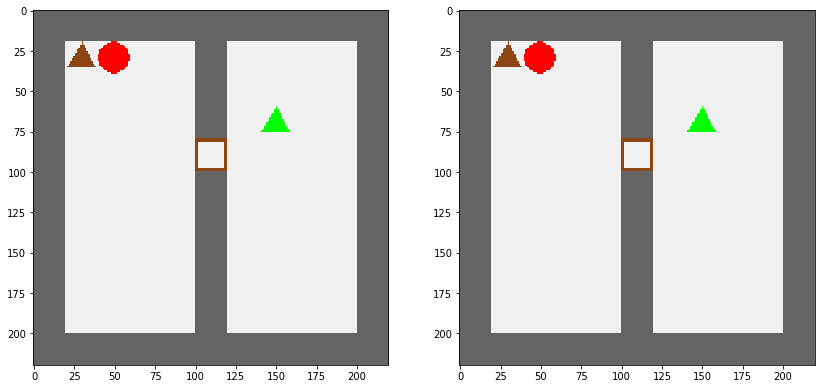

In [8]:
from env.gridworld.dataset import LogDatabase
import tqdm.notebook
import h5py
import pathlib

# Create log database in case previous cell was not run
log = LogDatabase(path=paths.data)

path = paths.data
dataset = "dataset_gridworld.hdf5"

def show_data(path, dataset, idx):

    with h5py.File(pathlib.Path(path) / dataset, "r") as f:
        #print(f.keys())
        
        # Get dsets
        img_pre_dset = f["img_pre"]
        img_post_dset = f["img_post"]
        key_dset = f["keys"]
        action_dset = f["actions"]
        boxes_pre_dset = f["boxes_pre"]
        boxes_post_dset = f["boxes_post"]
        s_post_dset = f["s_post"]
        s_pre_dset = f["s_pre"]
        
        #print(img_pre_dset.shape)
        #print(key_dset.shape)
    
        print("Key: {} . Action: {}".format(key_dset[idx], action_dset[idx]))
        print("Boxes pre: ")
        print(boxes_pre_dset[idx])
        
        print("Boxes post: ")
        print(boxes_post_dset[idx])
        
        print("S pre")
        print(s_pre_dset[idx])
        
        img_pre = img_pre_dset[idx]
        img_post = img_post_dset[idx]
        
        fig = plt.figure(figsize=(14,7))
        ax1 = plt.subplot(121)
        ax1.imshow(img_pre, interpolation='none')
        ax2 = plt.subplot(122)
        ax2.imshow(img_post, interpolation='none')
        plt.show()
                
        # Save
        log.key = idx
        save_images(log, img_pre, img_post)
            
# Test with an idx    
idx = 2003
show_data(path, dataset, idx)

#log.publish_dataset("dataset.hdf5", tqdm=tqdm.notebook.tqdm)